# Import libraries

In [1]:
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_validate,
    StratifiedKFold,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_curve,
    auc,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import pandas as pd
import seaborn as sns

In [2]:
train_master = pd.read_csv("data/train.csv")
train = train_master.copy()
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [4]:
train.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

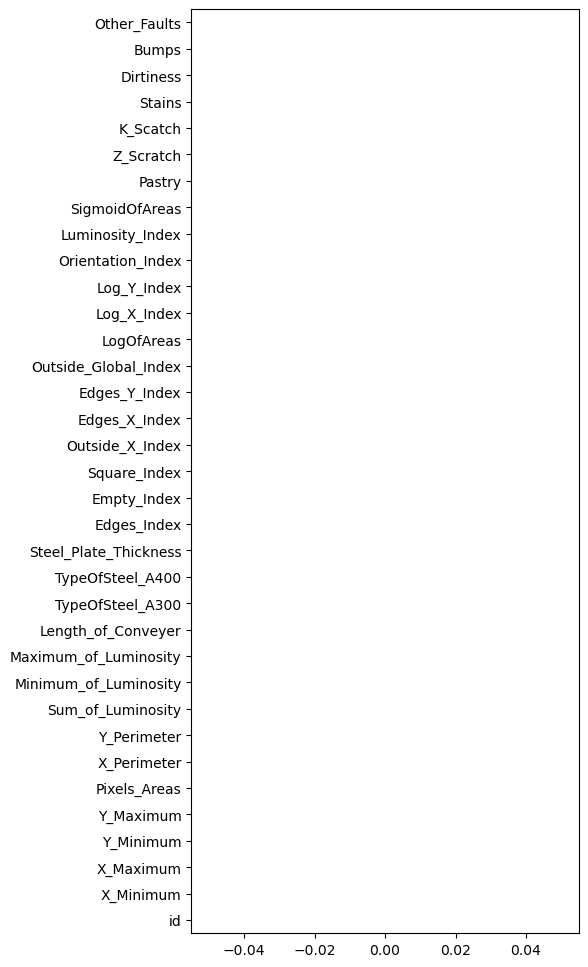

In [9]:
plt.figure(figsize=(5, 12))
train.isnull().sum().plot(kind="barh")
plt.show()

In [10]:
train.duplicated().sum()

0

In [11]:
train.drop("id", axis=1, inplace=True)
train.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [23]:
train = pd.melt(train, id_vars=train.columns[:-7], value_vars=train.columns[-7:], var_name='Fault_Type')
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Fault_Type,value
0,584,590,909972,909977,16,8,5,2274,113,140,...,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,Pastry,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,Pastry,0
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,Pastry,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,Pastry,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,Pastry,0


# Metrics

# Model building

In [24]:
features = train.drop("Fault_Type", axis=1)
target = train["Fault_Type"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, shuffle=True, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(107626, 28)
(26907, 28)


# Model evaluation

# Submission